In [4]:
import pandas as pd
import numpy as np
import sktime

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

In [16]:
df = pd.read_csv('../data/cleaned/campus5.csv', index_col='Timestamp')
df.index = pd.to_datetime(df.index)
df= df.asfreq(freq='15T')

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='SolarGeneration'>)

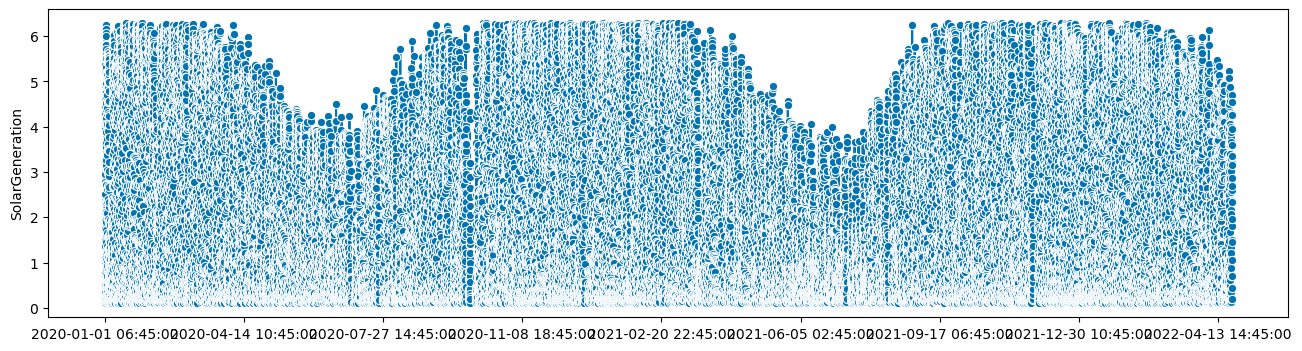

In [17]:
plot_series(df['SolarGeneration'])

In [18]:
y_train, y_test = temporal_train_test_split(df['SolarGeneration'], test_size=0.15)

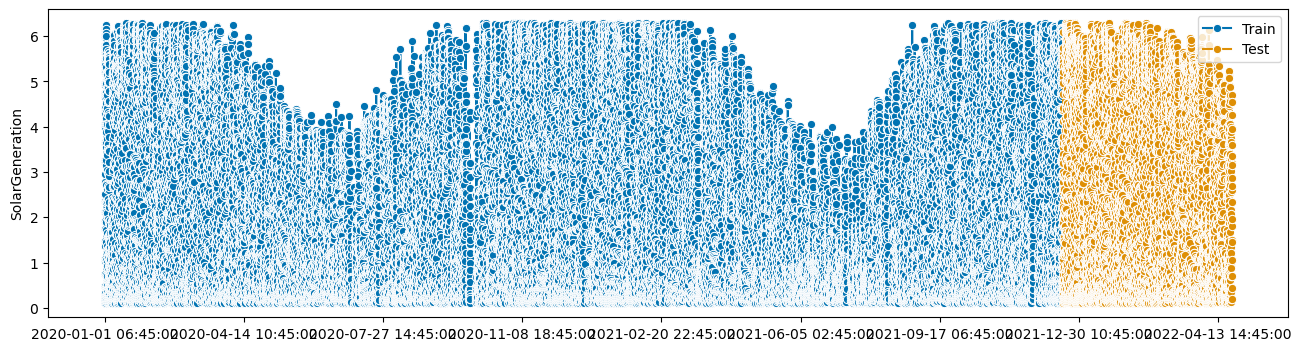

In [19]:
plot_series(y_train, y_test, labels = ['Train', 'Test']);

In [21]:
baseline = NaiveForecaster()
baseline.fit(y_train)
baseline_preds = baseline.predict(y_test.index)

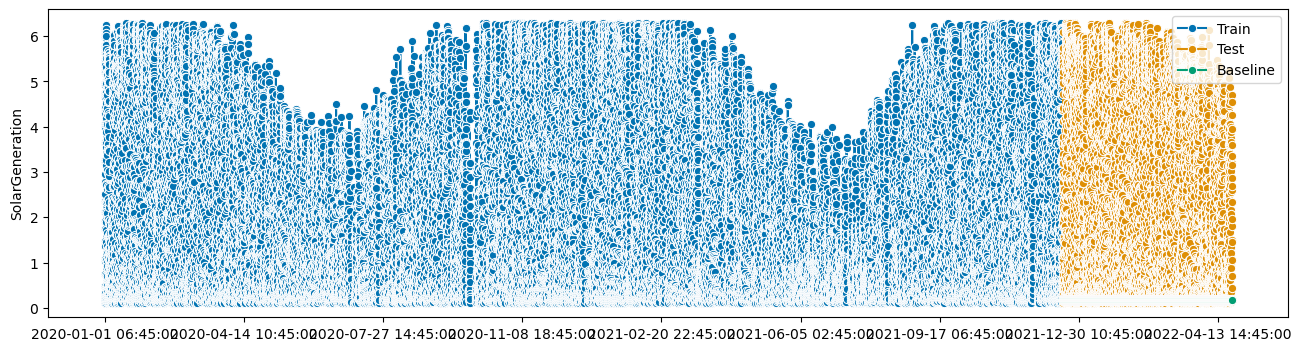

In [22]:
plot_series(y_train, y_test, baseline_preds, labels = ['Train', 'Test', 'Baseline']);